<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Algorithmic Trading

## With Machine & Deep Learning

**Market Prediction with Simple Neural Network**

**_ODSC Europe 2017_**

Dr. Yves J. Hilpisch

The Python Quants GmbH

**12. October 2017**

<img src="http://hilpisch.com/images/finaince_visual_low.png" width=50% align=left>

## The Imports

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
from pandas_datareader import data as web
%matplotlib inline

In [2]:
print("Please note the Google Finance URL used is: {}".format(web.GoogleDailyReader().url))
print("This might be wrong as the URL changed September 2017, as per the discussion",
      "at https://github.com/pydata/pandas-datareader/issues/391")
print("Until the fixed URL is built into the library, it can be modified manually in `google/daily.py`")
print("In any case, note that not all data is available via that feed, which is why the `h5` file is provided.")

Please note the Google Finance URL used is: http://finance.google.com/finance/historical
This might be wrong as the URL changed September 2017, as per the discussion at https://github.com/pydata/pandas-datareader/issues/391
Until the fixed URL is built into the library, it can be modified manually in `google/daily.py`
In any case, note that not all data is available via that feed, which is why the `h5` file is provided.


## Raw Data & Features

In [3]:
h5 = pd.HDFStore('../data/equities.h5', 'r')

In [4]:
df = h5['data']

In [5]:
h5.close()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4351 entries, 2000-01-03 to 2017-04-19
Data columns (total 7 columns):
AAPL      4351 non-null float64
MSFT      4351 non-null float64
YHOO      4351 non-null float64
^GDAXI    4297 non-null float64
^GSPC     4351 non-null float64
^VIX      4351 non-null float64
^SSMI     4274 non-null float64
dtypes: float64(7)
memory usage: 271.9 KB


In [7]:
raw = pd.DataFrame(df['^GDAXI'])

In [44]:
# This has some issues due to the September 2017 Google Finance changes
raw = pd.DataFrame(web.DataReader('DAX', data_source='google')['Close'])

In [8]:
raw.columns = ['prices']

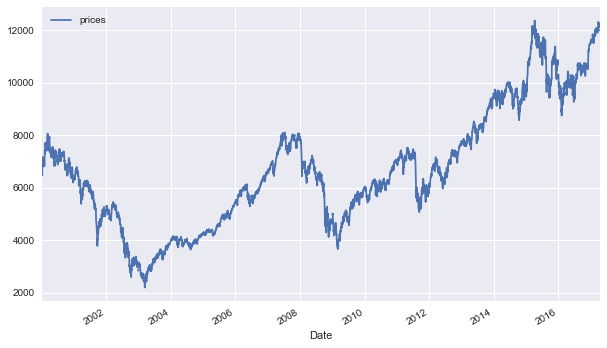

In [9]:
raw.plot(figsize=(10, 6));

In [10]:
raw['log_rets'] = np.log(raw['prices'] / raw['prices'].shift(1))
raw.dropna(inplace=True)
raw['returns'] = np.where(raw['log_rets'] > 0, 1, 0)

In [11]:
lags = 3

In [12]:
cols = []
for lag in range(1, lags+1):
    col = 'lag_%d' % lag
    raw[col] = raw['log_rets'].shift(lag)
    cols.append(col)

In [13]:
raw['SMA'] = raw['prices'].rolling(10).mean()
raw['trend'] = ((raw['prices'] - raw['SMA']) > 0).astype(int).shift(1)

In [14]:
raw.head()

,prices,log_rets,returns,lag_1,lag_2,lag_3,SMA,trend
Date,,,,,,,,
2000-01-04,6586.950195,-0.024565,0,NaN,NaN,NaN,NaN,NaN
2000-01-05,6502.069824,-0.012970,0,-0.024565,NaN,NaN,NaN,0.0
2000-01-06,6474.919922,-0.004184,0,-0.012970,-0.024565,NaN,NaN,0.0
2000-01-07,6780.959961,0.046182,1,-0.004184,-0.012970,-0.024565,NaN,0.0
2000-01-10,6925.520020,0.021094,1,0.046182,-0.004184,-0.012970,NaN,0.0


In [15]:
mean = raw['log_rets'].mean()
std = raw['log_rets'].std()

In [16]:
def buckets(x):
    bounds = [mean-std, 0, mean, mean+std]
    for i, b in enumerate(sorted(bounds)):
        if x < b: return i
    else: return i + 1

In [17]:
for _ in cols:
    raw[_] = raw[_].apply(buckets)

In [18]:
cols.append('trend')
lags +=1

In [19]:
raw.head()

,prices,log_rets,returns,lag_1,lag_2,lag_3,SMA,trend
Date,,,,,,,,
2000-01-04,6586.950195,-0.024565,0,4,4,4,NaN,NaN
2000-01-05,6502.069824,-0.012970,0,0,4,4,NaN,0.0
2000-01-06,6474.919922,-0.004184,0,1,0,4,NaN,0.0
2000-01-07,6780.959961,0.046182,1,1,1,0,NaN,0.0
2000-01-10,6925.520020,0.021094,1,4,1,1,NaN,0.0


<img src="http://hilpisch.com/images/finaince_logo.png" width=300px align=left>

## Neural Network Training &mdash; Small Data Set

In [20]:
data = raw.dropna().iloc[-10:].copy()

In [21]:
data

,prices,log_rets,returns,lag_1,lag_2,lag_3,SMA,trend
Date,,,,,,,,
2017-04-03,12257.200195,-0.004532,0,3,3,3,12114.518945,1.0
2017-04-04,12282.339844,0.002049,1,1,3,3,12146.539941,1.0
2017-04-05,12217.540039,-0.005290,0,3,1,3,12177.881934,1.0
2017-04-06,12230.889648,0.001092,1,1,3,1,12197.002930,1.0
2017-04-07,12225.059570,-0.000477,0,3,1,3,12213.081934,1.0
2017-04-10,12200.519531,-0.002009,0,1,3,1,12233.526855,1.0
2017-04-11,12139.349609,-0.005026,0,1,1,3,12232.519824,0.0
2017-04-12,12154.700195,0.001264,1,1,1,1,12227.689844,0.0
2017-04-13,12109.000000,-0.003767,0,3,1,1,12212.946875,0.0


In [22]:
x = data[cols].values
x.astype(int)

array([[3, 3, 3, 1],
       [1, 3, 3, 1],
       [3, 1, 3, 1],
       [1, 3, 1, 1],
       [3, 1, 3, 1],
       [1, 3, 1, 1],
       [1, 1, 3, 0],
       [1, 1, 1, 0],
       [3, 1, 1, 0],
       [1, 3, 1, 0]])

In [23]:
y = data['returns'].values.reshape((1, -1)).T
y

array([[0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1]])

In [24]:
# initialize weights randomly with mean 0
np.random.seed(1)
weights = 2 * np.random.random((lags, 1)) - 1
weights

array([[-0.16595599],
       [ 0.44064899],
       [-0.99977125],
       [-0.39533485]])

In [25]:
# sigmoid function
def sigmoid(x, deriv=False):
    if deriv == True:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

In [26]:
for _ in range(201):
    # forward propagation
    # layer 1
    l1 = sigmoid(np.dot(x, weights))

    # errors of layer 1
    e = y - l1
    if _ % 200 == 0:
        print('\nafter %d iterations' % _)
        print('MSE:    ', (e ** 2).mean())

    # multiply errors by the slope of the 
    # sigmoid at the values in l1
    d = e * sigmoid(l1, True)

    # update weights
    weights += np.dot(x.T, d)


after 0 iterations
MSE:     0.206736958195

after 200 iterations
MSE:     0.156683860336


In [27]:
print(l1.round().astype(int).T)
print(y.T)

[[0 0 0 1 0 1 0 0 0 1]]
[[0 1 0 1 0 0 0 1 0 1]]


In [28]:
l1.round() == y

array([[ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True]], dtype=bool)

## Neural Network Training &mdash; Bigger Data Set

A cut-off date is used instead of just using the last ten entries. 

### Training

In [29]:
cutoff = '2009-1-1'

In [30]:
data = raw[raw.index < cutoff].dropna().copy()

In [31]:
# initialize weights randomly with mean 0
np.random.seed(1)
weights = 2 * np.random.random((lags, 1)) - 1
weights

array([[-0.16595599],
       [ 0.44064899],
       [-0.99977125],
       [-0.39533485]])

In [32]:
x = data[cols].values

In [33]:
y = data['returns'].values.reshape((1, -1)).T

In [34]:
for _ in range(1001):
    # forward propagation
    # layer 1
    l1 = sigmoid(np.dot(x, weights))

    # errors of layer 1
    e = y - l1
    if _ % 200 == 0:
        print('\nafter %d iterations' % _)
        print('MSE:    ', (e ** 2).mean())

    # multiply errors by the slope of the 
    # sigmoid at the values in l1
    d = e * sigmoid(l1, True)

    # update weights
    weights += 0.001 * np.dot(x.T, d)


after 0 iterations
MSE:     0.374704210808

after 200 iterations
MSE:     0.249062883733

after 400 iterations
MSE:     0.249062112447

after 600 iterations
MSE:     0.249062112072

after 800 iterations
MSE:     0.249062112069

after 1000 iterations
MSE:     0.249062112069


In [35]:
print(l1.round().astype(int).T)
print(y.T)

[[0 1 1 ..., 0 0 1]]
[[0 1 1 ..., 0 1 1]]


In [36]:
sum(y) / len(y)

array([ 0.51916058])

In [37]:
sum(l1.round() == y) / len(data)

array([ 0.51551095])

In [38]:
data['pred'] = np.where(l1.round() > 0, 1, -1)

In [39]:
data['strategy'] = data['log_rets'] * data['pred']

In [40]:
data.head()

,prices,log_rets,returns,lag_1,lag_2,lag_3,SMA,trend,pred,strategy
Date,,,,,,,,,,
2000-01-18,7072.120117,-0.014194,0,4,3,3,6827.580029,0.0,-1,0.014194
2000-01-19,7091.040039,0.002672,1,1,4,3,6877.989014,1.0,1,0.002672
2000-01-20,7112.660156,0.003044,1,3,1,4,6939.048047,1.0,1,0.003044
2000-01-21,6992.750000,-0.017002,0,3,3,1,6990.831055,1.0,1,-0.017002
2000-01-24,6931.990234,-0.008727,0,0,3,3,7005.934082,1.0,1,-0.008727


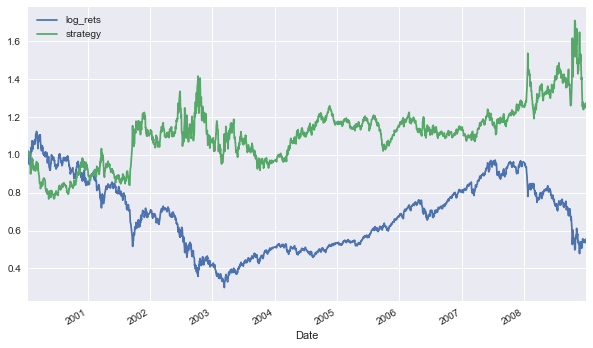

In [41]:
data[['log_rets', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Testing

In [42]:
weights

array([[-0.03934092],
       [-0.01149524],
       [-0.01077916],
       [ 0.27719233]])

In [43]:
data = raw[raw.index > cutoff].dropna().copy()

In [44]:
x = data[cols].values

In [45]:
l1 = sigmoid(np.dot(x, weights))

In [46]:
l1.round()

array([[ 1.],
       [ 1.],
       [ 1.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [47]:
y = data['returns'].values.reshape((1, -1)).T

In [48]:
y

array([[1],
       [1],
       [0],
       ..., 
       [1],
       [0],
       [1]])

In [49]:
sum(y) / len(y)

array([ 0.5383488])

In [50]:
sum(l1.round() == y) / len(data)

array([ 0.4963361])

In [51]:
data['pred'] = np.where(l1.round() > 0, 1, -1)

In [52]:
data['strategy'] = data['log_rets'] * data['pred']

In [53]:
data.head()

,prices,log_rets,returns,lag_1,lag_2,lag_3,SMA,trend,pred,strategy
Date,,,,,,,,,,
2009-01-05,4983.990234,0.002194,1,4,4,2,4718.768994,1.0,1,0.002194
2009-01-06,5026.310059,0.008455,1,3,4,4,4750.562012,1.0,1,0.008455
2009-01-07,4937.470215,-0.017833,0,3,3,4,4768.669043,1.0,1,-0.017833
2009-01-08,4879.910156,-0.011726,0,0,3,3,4786.990039,1.0,1,-0.011726
2009-01-09,4783.890137,-0.019873,0,1,0,3,4801.477051,1.0,1,-0.019873


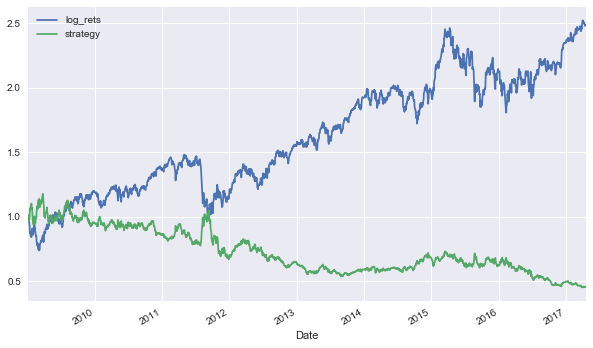

In [54]:
data[['log_rets', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

This comes to show that a strategy which works with past data is not always a good strategy going forward. Especially when using pattern matching models which might heavily overfit the given training dataset.

<img src="http://hilpisch.com/tpq_logo.png" width=350px align="right">